In [1]:
# Installing Dependencies
from IPython.display import clear_output as clr
!python --version
!pip install --upgrade luxai_s2
!pip install importlib-metadata==4.13.0
!pip install gym==0.19
clr()

In [2]:
# Copying Files to local folder where program is being run...
!cp -r ../input/lux-ai-season-2/* .
clr()

In [3]:
from luxai_s2.env import LuxAI_S2
import matplotlib.pyplot as plt
import numpy as np
import dataclasses
import json
from luxai_runner.utils import to_json
from IPython import get_ipython
from IPython.display import display, HTML, Javascript
import time
import os

Player_names: ['player_0', 'player_1']
Observation Keys: ['units', 'teams', 'factories', 'board', 'real_env_steps', 'global_id']


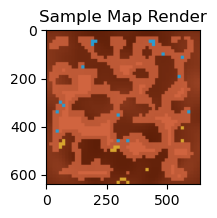

In [4]:
env = LuxAI_S2() # Environment 
obs = env.reset(seed=np.random.randint(1000))
print("Player_names: {}\nObservation Keys: {}".format(list(obs.keys()), list(obs["player_0"].keys())))
img = env.render("rgb_array", width=640, height=640)
plt.figure(figsize = [2,2])
plt.imshow(img)
plt.title("Sample Map Render")
plt.show()

In [5]:
%%writefile agent.py 
### Comment above given line to avoid overwriting old agent file ###

from lux.kit import obs_to_game_state, GameState, EnvConfig
from lux.kit import Board
from lux.utils import direction_to, my_turn_to_place_factory
import numpy as np
import sys
class Agent():
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg
            
        self.faction_names = {
            'player_0': 'TheBuilders',
            'player_1': 'FirstMars' 
        }
        
        self.bots = {}
        self.botpos = []
        self.bot_factory = {}
        self.factory_bots = {}
        self.factory_queue = {}
        self.move_deltas = np.array([[0, 0], [0, -1], [1, 0], [0, 1], [-1, 0]])

    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        '''
        Early Phase
        '''
        
        actions = dict()
        if step == 0:
            # Declare faction
            actions['faction'] = self.faction_names[self.player]
            actions['bid'] = 0 # Learnable
        else:
            # Factory placement period
            # optionally convert observations to python objects with utility functions
            game_state = obs_to_game_state(step, self.env_cfg, obs) 
            opp_factories = [f.pos for _,f in game_state.factories[self.opp_player].items()]
            my_factories = [f.pos for _,f in game_state.factories[self.player].items()]
            
            # how much water and metal you have in your starting pool to give to new factories
            water_left = game_state.teams[self.player].water
            metal_left = game_state.teams[self.player].metal
            
            # how many factories you have left to place
            factories_to_place = game_state.teams[self.player].factories_to_place
            my_turn_to_place = my_turn_to_place_factory(game_state.teams[self.player].place_first, step)
            if factories_to_place > 0 and my_turn_to_place:
                # we will spawn our factory in a random location with 100 metal n water (learnable)
                potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
                
                ice_map = game_state.board.ice
                ore_map = game_state.board.ore
                
                ice_tile_locations = np.argwhere(ice_map == 1) # numpy position of every ice tile
                ore_tile_locations = np.argwhere(ore_map == 1) # numpy position of every ice tile
                
                min_dist = 10e6
                best_loc = potential_spawns[0]
                
                d_rubble = 10
                
                for loc in potential_spawns:
                    
                    ice_tile_distances = np.mean((ice_tile_locations - loc) ** 2, 1)
                    ore_tile_distances = np.mean((ore_tile_locations - loc) ** 2, 1)
                    density_rubble = np.mean(obs["board"]["rubble"][max(loc[0]-d_rubble,0):min(loc[0]+d_rubble,47), max(loc[1]-d_rubble,0):max(loc[1]+d_rubble,47)])
                    
                    closes_opp_factory_dist = 0
                    if len(opp_factories) >= 1:
                        closes_opp_factory_dist = np.min(np.mean((np.array(opp_factories) - loc)**2, 1))
                    closes_my_factory_dist = 0
                    if len(my_factories) >= 1:
                        closes_my_factory_dist = np.min(np.mean((np.array(my_factories) - loc)**2, 1))
                    
                    minimum_ice_dist = np.min(ice_tile_distances)*10 + 0.01*np.min(ore_tile_distances) + 10*density_rubble/(d_rubble) - closes_opp_factory_dist*0.1 + closes_opp_factory_dist*0.01
                    
                    if minimum_ice_dist < min_dist:
                        min_dist = minimum_ice_dist
                        best_loc = loc
                
#                 spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
                spawn_loc = best_loc
                actions['spawn']=spawn_loc
#                 actions['metal']=metal_left
#                 actions['water']=water_left
                feat_cost=150
                actions['metal']=min(feat_cost, water_left)
                actions['water']=min(feat_cost, metal_left)
            
        return actions
    
    def check_collision(self, pos, direction, unitpos, unit_type = 'LIGHT'):
        move_deltas = self.move_deltas#np.array([[0, 0], [0, -1], [1, 0], [0, 1], [-1, 0]])
#         move_deltas = np.array([[0, 0], [-1, 0], [0, 1], [1, 0], [0, -1]])
        
        new_pos = pos + move_deltas[direction]
        
        
        if unit_type == "LIGHT":
            return str(new_pos) in unitpos or str(new_pos) in self.botposheavy.values()
        else:
            return str(new_pos) in unitpos
    
    def get_direction(self,unit, closest_tile, sorted_tiles):
        
        closest_tile = np.array(closest_tile)
        direction = direction_to(np.array(unit.pos), closest_tile)
        k=0
        all_unit_positions = set(self.botpos.values())
        unit_type = unit.unit_type
        while self.check_collision(np.array(unit.pos), direction, all_unit_positions, unit_type) and k < min(len(sorted_tiles)-1, 500):
            k += 1
            closest_tile = sorted_tiles[k]
            closest_tile = np.array(closest_tile)
            direction = direction_to(np.array(unit.pos), closest_tile)
        
        if self.check_collision(unit.pos, direction, all_unit_positions, unit_type):
            for direction_x in np.arange(4,-1,-1):
                if not self.check_collision(np.array(unit.pos), direction_x, all_unit_positions, unit_type):
                    direction = direction_x
                    break

#         elif self.check_collision(np.array(unit.pos), direction, all_unit_positions, unit_type):
#             direction = np.random.choice(np.arange(5))
            
        move_deltas = self.move_deltas#np.array([[0, 0], [0, -1], [1, 0], [0, 1], [-1, 0]])
        
        self.botpos[unit.unit_id] = str(np.array(unit.pos) + move_deltas[direction])
        
        return direction

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        '''
        1. Regular Phase
        2. Building Robots
        '''
        actions = dict()
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        state_obs = obs
        
        # Unit locations
        self.botpos = {}
        self.botposheavy = {}
        self.opp_botpos = []
        for player in [self.player, self.opp_player]:
            for unit_id, unit in game_state.units[player].items():
                
                if player == self.player:
                    self.botpos[unit_id] = str(unit.pos)
                else:
                    self.opp_botpos.append(unit.pos)
                    
                
                if unit.unit_type == "HEAVY":
                    self.botposheavy[unit_id] = str(unit.pos)
        
        # Build Robots
        factories = game_state.factories[self.player]
        factory_tiles, factory_units, factory_ids = [], [], []
        bot_units = {}
        
        for unit_id, factory in factories.items():
            
            if unit_id not in self.factory_bots.keys():
                self.factory_bots[unit_id] = {
                    'ice':[],
                    'ore':[],
                    'rubble':[],
                    'kill':[],
                }
                
                self.factory_queue[unit_id] = []
            
            for task in ['ice', 'ore', 'rubble', 'kill']:
                for bot_unit_id in self.factory_bots[unit_id][task]:
                    if bot_unit_id not in self.botpos.keys():
                        self.factory_bots[unit_id][task].remove(bot_unit_id)
            
            prod_fac=len(factories)
            minbot_task = None
            min_bots = {
                'ice':1,
                'ore':4,
                'rubble':4,
                'kill':0
            }
            # NO. BOTS PER TASK
            for task in ['kill', 'ice', 'ore', 'rubble']:
                num_bots = len(self.factory_bots[unit_id][task]) + sum([task in self.factory_queue[unit_id]])
                if num_bots < min_bots[task]:
                    minbots = num_bots
                    minbot_task = task
                    break
                    
#             try:
#                 print(factory.power, self.env_cfg.ROBOTS["LIGHT"].POWER_COST,factory.cargo.metal,self.env_cfg.ROBOTS["LIGHT"].METAL_COST,step)
#                 # 1000 50 250 10 11
#             except:
#                 assert False
#             print(len(minbot_task))

            if minbot_task is not None:
                if minbot_task in ['kill'] and step>500 :
                    #heavy robots are prefered over light for kill and ice retrival
                    if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
                    factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                        actions[unit_id] = factory.build_heavy()
                        
                        
                elif minbot_task in ["ore"]:
                    
                    #light robots are prefered over heavy for ore collection and rubble removal
                    
                    if factory.power >= self.env_cfg.ROBOTS["LIGHT"].POWER_COST and \
                    factory.cargo.metal >= self.env_cfg.ROBOTS["LIGHT"].METAL_COST and step<690:
                        actions[unit_id] = factory.build_light()
                        
                    elif factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
                    factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                        actions[unit_id] = factory.build_heavy()
                        
                elif minbot_task in ["rubble"] and step>100:
                    #light robots are prefered over heavy for ore collection and rubble removal
                    if factory.power >= self.env_cfg.ROBOTS["LIGHT"].POWER_COST and \
                    factory.cargo.metal >= self.env_cfg.ROBOTS["LIGHT"].METAL_COST and step<690:
                        actions[unit_id] = factory.build_light()
                        
                    elif factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
                    factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                        actions[unit_id] = factory.build_heavy()
                        
                elif minbot_task in ['ice']:
                    #heavy robots are prefered over light for kill and ice retrival
                    if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
                    factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                        actions[unit_id] = factory.build_heavy()

                #dont know what and why 
                if unit_id not in self.factory_queue.keys():
                    self.factory_queue[unit_id] = [minbot_task]
                else:
                    self.factory_queue[unit_id].append(minbot_task)

            factory_tiles += [factory.pos]
            factory_units += [factory]
            factory_ids += [unit_id]
            #produce lichens
            if factory.can_water(game_state) and step > 700 and factory.cargo.water > (1000-step)+100:
                actions[unit_id] = factory.water()
        
        factory_tiles = np.array(factory_tiles) # Factory locations (to go back to)
            
        # Move Robots
        # iterate over our units and have them mine the closest ice tile
        units = game_state.units[self.player]
        
        # Resource map and locations
        ice_map = game_state.board.ice
        ore_map = game_state.board.ore
        rubble_map = game_state.board.rubble
        
        ice_locations_all = np.argwhere(ice_map >= 1) # numpy position of every ice tile
        ore_locations_all = np.argwhere(ore_map >= 1) # numpy position of every ore tile
        rubble_locations_all = np.argwhere(rubble_map >= 1) # numpy position of every rubble tile
        
        ice_locations = ice_locations_all
        ore_locations = ore_locations_all
        rubble_locations = rubble_locations_all
        
        #destruction phase after 900
        
        opp_factories = np.array([f.pos for _,f in game_state.factories[self.opp_player].items()])
        lichen_map = game_state.board.lichen
        lichen_locations_all = np.argwhere(lichen_map >= 1)
        lichen_locations = lichen_locations_all
            
        for unit_id, unit in iter(sorted(units.items())):
            
            if unit_id not in self.bots.keys():
                self.bots[unit_id] = ''
                
            if len(factory_tiles) > 0:
                closest_factory_tile = factory_tiles[0]
            
            if unit_id not in self.bot_factory.keys():
                factory_distances = np.mean((factory_tiles - unit.pos) ** 2, 1)
                min_index = np.argmin(factory_distances)
                closest_factory_tile = factory_tiles[min_index]
                self.bot_factory[unit_id] = factory_ids[min_index]
                
            elif self.bot_factory[unit_id] not in factory_ids:
                factory_distances = np.mean((factory_tiles - unit.pos) ** 2, 1)
                min_index = np.argmin(factory_distances)
                closest_factory_tile = factory_tiles[min_index]
                self.bot_factory[unit_id] = factory_ids[min_index]
            else:
                closest_factory_tile = factories[self.bot_factory[unit_id]].pos
                
                
            distance_to_factory = np.mean((np.array(closest_factory_tile) - np.array(unit.pos))**2)
            adjacent_to_factory = False
            sorted_factory = [closest_factory_tile]
            
            if unit.power < unit.action_queue_cost(game_state):
                continue
                
            if len(factory_tiles) > 0:
                
                move_cost = None
                try:
                    adjacent_to_factory = np.mean((np.array(closest_factory_tile) - np.array(unit.pos)) ** 2) <= 1
                except:
                    print(closest_factory_tile, unit.pos)
                    assert False
                
                ## Assigning task for the bot with no role
                if self.bots[unit_id] == '':
                    task = 'ice'
                    if len(self.factory_queue[self.bot_factory[unit_id]]) != 0:
                        task = self.factory_queue[self.bot_factory[unit_id]].pop(0)
                    self.bots[unit_id] = task
                    self.factory_bots[self.bot_factory[unit_id]][task].append(unit_id)
                
                battery_capacity = 150 if unit.unit_type == "LIGHT" else 3000
                cargo_space = 100 if unit.unit_type == "LIGHT" else 1000
                def_move_cost = 1 if unit.unit_type == "LIGHT" else 20
                rubble_dig_cost = 5 if unit.unit_type == "LIGHT" else 100
                
                def ice_devi(game):
                    """if water in home factory > 169 leave base otherwise -> no """
                    rubble_distances = np.mean((rubble_locations - unit.pos) ** 2, 1)
                    sorted_rubble = [rubble_locations[k] for k in np.argsort(rubble_distances)]
                    closest_rubble = sorted_rubble[0]
                    temp=np.array(closest_rubble) - np.array(unit.pos) ** 2
                    temp=temp[0]+temp[1]
                    
                    comp=9
                    if step>700:
                        comp=1
                        
                    if temp >=comp:
                        return False
#                     closest_factory = factories[self.bot_factory[unit_id]]
#                     print(game_state.factories[closest_factory])
                    
                    return True
                
                
                
                if self.bots[unit_id] == "ice":
                    fl=True
                    dd=True
                    
                    try:
                        if len(self.opp_botpos) != 0:
                            opp_pos = np.array(self.opp_botpos).reshape(-1,2)
                            opponent_unit_distances = np.mean((opp_pos - unit.pos)**2,1)
                            min_distance = np.min(opponent_unit_distances)
                            pos_min_distance = opp_pos[np.argmin(min_distance)]
                            n=1
                            if step<169:
                                n=49

                            if min_distance <= n :
                                fl=False
                                direction = self.get_direction(unit, np.array(pos_min_distance), [np.array(pos_min_distance)])
                                move_cost = unit.move_cost(game_state, direction)
                    except:
                        pass
                    
                    if ice_devi(game_state) and False:
                        try:
                            if step>690 and step > 800:
                                rubble_distances = np.mean((rubble_locations - unit.pos) ** 2, 1)
                                sorted_rubble = [rubble_locations[k] for k in np.argsort(rubble_distances)]
                                closest_rubble = sorted_rubble[0]

                                # if we have reached the rubble tile, start mining if possible
                                if np.all(closest_rubble == unit.pos) or rubble_map[unit.pos[0], unit.pos[1]] != 0:
                                    if unit.power >= unit.dig_cost(game_state) +\
                                    unit.action_queue_cost(game_state):
                                        actions[unit_id] = [unit.dig(repeat=False)]
                                        dd=False
                                else:
                                    if len(rubble_locations) != 0:
                                        direction = self.get_direction(unit, closest_rubble, sorted_rubble)
                                        move_cost = unit.move_cost(game_state, direction)
                                        dd=False
                        except:
                            pass
                    
                    if unit.cargo.ice < cargo_space and unit.power > unit.action_queue_cost(game_state) + unit.dig_cost(game_state) + def_move_cost*distance_to_factory  and fl and dd:

                        # compute the distance to each ice tile from this unit and pick the closest
                        
                        ice_rubbles = np.array([rubble_map[pos[0]][pos[1]] for pos in ice_locations])
                        ice_distances = np.mean((ice_locations - unit.pos) ** 2, 1) #- (ice_rubbles)*10
                        sorted_ice = [ice_locations[k] for k in np.argsort(ice_distances)]
                        
                        closest_ice = sorted_ice[0]
                        # if we have reached the ice tile, start mining if possible
                        if np.all(closest_ice == unit.pos):
                            if unit.power >= unit.dig_cost(game_state) +\
                            unit.action_queue_cost(game_state):
                                actions[unit_id] = [unit.dig(repeat=False)]
                        else:
                            direction = self.get_direction(unit, closest_ice, sorted_ice)
                            move_cost = unit.move_cost(game_state, direction)

                    elif unit.cargo.ice >= cargo_space or unit.power <= unit.action_queue_cost(game_state) + unit.dig_cost(game_state) + def_move_cost*distance_to_factory:

                        if adjacent_to_factory:
                            if unit.cargo.ice > 0:
                                actions[unit_id] = [unit.transfer(0, 0, unit.cargo.ice, repeat=False)]
                            elif unit.cargo.ore > 0:
                                actions[unit_id] = [unit.transfer(0, 1, unit.cargo.ore, repeat=False)]
                            elif unit.power < battery_capacity*0.1:
                                actions[unit_id] = [unit.pickup(4, battery_capacity-unit.power)]
                        else:
                            direction = self.get_direction(unit, closest_factory_tile, sorted_factory)
                            move_cost = unit.move_cost(game_state, direction)
                
                elif self.bots[unit_id] in ['rubble'] and step>860:
                    fl=True
                    try:
                        if len(self.opp_botpos) != 0:
                            opp_pos = np.array(self.opp_botpos).reshape(-1,2)
                            opponent_unit_distances = np.mean((opp_pos - unit.pos)**2,1)
                            min_distance = np.min(opponent_unit_distances)
                            pos_min_distance = opp_pos[np.argmin(min_distance)]

                            if min_distance == 1 or min_distance<=3:
                                fl=False
                                direction = self.get_direction(unit, np.array(pos_min_distance), [np.array(pos_min_distance)])
                                move_cost = unit.move_cost(game_state, direction)
                    except:
                        pass

                    if unit.power > unit.action_queue_cost(game_state) + unit.dig_cost(game_state) + rubble_dig_cost and fl:

                        # compute the distance to each rubble tile from this unit and pick the closest
                        closest_factory_with_lichen = [opp_factories[k] for k in np.argsort(np.mean((opp_factories - unit.pos) ** 2, 1))][0]
#                         lichen_location =np.mean((lichen_locations  - closest_factory_with_lichen) ** 2, 1)
#                         print(lichen_location.shape)
                        lichen_distances = np.mean((lichen_locations  - closest_factory_with_lichen) ** 2, 1)
                        sorted_lichen = [lichen_locations[k] for k in np.argsort(lichen_distances)]
                        closest_lichen=unit.pos
                        if len(sorted_lichen)!=0:
                            closest_lichen = sorted_lichen[0]
                        else:
                            rubble_distances = np.mean((rubble_locations - unit.pos) ** 2, 1)
                            sorted_rubble = [rubble_locations[k] for k in np.argsort(rubble_distances)]
                            closest_lichen = sorted_rubble[0]
                            

                        # if we have reached the lichen tile, start mining if possible
                        if np.all(closest_lichen == unit.pos):
                            if unit.power >= unit.dig_cost(game_state) +\
                            unit.action_queue_cost(game_state):
                                actions[unit_id] = [unit.dig(repeat=False)]
                        else:
                            if len(lichen_locations) != 0:
                                direction = self.get_direction(unit, closest_lichen, sorted_lichen)
                                move_cost = unit.move_cost(game_state, direction)
            

                    elif unit.power <= unit.action_queue_cost(game_state) + unit.dig_cost(game_state) + rubble_dig_cost:

                        if adjacent_to_factory:
                            if unit.cargo.ore > 0:
                                actions[unit_id] = [unit.transfer(0, 1, unit.cargo.ore, repeat=False)]
                            elif unit.cargo.ice > 0:
                                actions[unit_id] = [unit.transfer(0, 0, unit.cargo.ice, repeat=False)]
                            elif unit.power < battery_capacity*0.1:
                                actions[unit_id] = [unit.pickup(4, battery_capacity-unit.power)]
                        else:
                            direction = self.get_direction(unit, closest_factory_tile, sorted_factory)
                            move_cost = unit.move_cost(game_state, direction)
                            
                elif self.bots[unit_id] in ['rubble',"ore"] and step>300 and step<800:
                    fl=True
                    try:
                        if len(self.opp_botpos) != 0:
                            opp_pos = np.array(self.opp_botpos).reshape(-1,2)
                            opponent_unit_distances = np.mean((opp_pos - unit.pos)**2,1)
                            min_distance = np.min(opponent_unit_distances)
                            pos_min_distance = opp_pos[np.argmin(min_distance)]

                            if min_distance <= 2:
                                fl=False
                                direction = self.get_direction(unit, np.array(pos_min_distance), [np.array(pos_min_distance)])
                                move_cost = unit.move_cost(game_state, direction)
                    except:
                        pass
                    if unit.power > unit.action_queue_cost(game_state) + unit.dig_cost(game_state) + rubble_dig_cost and fl:

                        # compute the distance to each rubble tile from this unit and pick the closest
                        rubble_distances = np.mean((rubble_locations - unit.pos) ** 2, 1)
                        sorted_rubble = [rubble_locations[k] for k in np.argsort(rubble_distances)]
                        closest_rubble = sorted_rubble[0]

                        # if we have reached the rubble tile, start mining if possible
                        if np.all(closest_rubble == unit.pos) or rubble_map[unit.pos[0], unit.pos[1]] != 0:
                            if unit.power >= unit.dig_cost(game_state) +\
                            unit.action_queue_cost(game_state):
                                actions[unit_id] = [unit.dig(repeat=False)]
                        else:
                            if len(rubble_locations) != 0:
                                direction = self.get_direction(unit, closest_rubble, sorted_rubble)
                                move_cost = unit.move_cost(game_state, direction)
            

                    elif unit.power <= unit.action_queue_cost(game_state) + unit.dig_cost(game_state) + rubble_dig_cost:

                        if adjacent_to_factory:
                            if unit.cargo.ore > 0:
                                actions[unit_id] = [unit.transfer(0, 1, unit.cargo.ore, repeat=False)]
                            elif unit.cargo.ice > 0:
                                actions[unit_id] = [unit.transfer(0, 0, unit.cargo.ice, repeat=False)]
                            elif unit.power < battery_capacity*0.1:
                                actions[unit_id] = [unit.pickup(4, battery_capacity-unit.power)]
                        else:
                            direction = self.get_direction(unit, closest_factory_tile, sorted_factory)
                            move_cost = unit.move_cost(game_state, direction)
                            
                elif self.bots[unit_id] in ['ore'] and step>900:
                    if unit.power > unit.action_queue_cost(game_state) + unit.dig_cost(game_state) + rubble_dig_cost:

                        # compute the distance to each rubble tile from this unit and pick the closest
                        rubble_distances = np.mean((rubble_locations - unit.pos) ** 2, 1)
                        sorted_rubble = [rubble_locations[k] for k in np.argsort(rubble_distances)]
                        closest_rubble = sorted_rubble[0]

                        # if we have reached the rubble tile, start mining if possible
                        if np.all(closest_rubble == unit.pos) or rubble_map[unit.pos[0], unit.pos[1]] != 0:
                            if unit.power >= unit.dig_cost(game_state) +\
                            unit.action_queue_cost(game_state):
                                actions[unit_id] = [unit.dig(repeat=False)]
                        else:
                            if len(rubble_locations) != 0:
                                direction = self.get_direction(unit, closest_rubble, sorted_rubble)
                                move_cost = unit.move_cost(game_state, direction)
            

                    elif unit.power <= unit.action_queue_cost(game_state) + unit.dig_cost(game_state) + rubble_dig_cost:

                        if adjacent_to_factory:
                            if unit.cargo.ore > 0:
                                actions[unit_id] = [unit.transfer(0, 1, unit.cargo.ore, repeat=False)]
                            elif unit.cargo.ice > 0:
                                actions[unit_id] = [unit.transfer(0, 0, unit.cargo.ice, repeat=False)]
                            elif unit.power < battery_capacity*0.1:
                                actions[unit_id] = [unit.pickup(4, battery_capacity-unit.power)]
                        else:
                            direction = self.get_direction(unit, closest_factory_tile, sorted_factory)
                            move_cost = unit.move_cost(game_state, direction)
                            
                elif self.bots[unit_id] in ['rubble'] and step<1000:
                    if unit.power > unit.action_queue_cost(game_state) + unit.dig_cost(game_state) + rubble_dig_cost:

                        # compute the distance to each rubble tile from this unit and pick the closest
                        rubble_distances = np.mean((rubble_locations - unit.pos) ** 2, 1)
                        sorted_rubble = [rubble_locations[k] for k in np.argsort(rubble_distances)]
                        closest_rubble = sorted_rubble[0]

                        # if we have reached the rubble tile, start mining if possible
                        if np.all(closest_rubble == unit.pos) or rubble_map[unit.pos[0], unit.pos[1]] != 0:
                            if unit.power >= unit.dig_cost(game_state) +\
                            unit.action_queue_cost(game_state):
                                actions[unit_id] = [unit.dig(repeat=False)]
                        else:
                            if len(rubble_locations) != 0:
                                direction = self.get_direction(unit, closest_rubble, sorted_rubble)
                                move_cost = unit.move_cost(game_state, direction)
            

                    elif unit.power <= unit.action_queue_cost(game_state) + unit.dig_cost(game_state) + rubble_dig_cost:

                        if adjacent_to_factory:
                            if unit.cargo.ore > 0:
                                actions[unit_id] = [unit.transfer(0, 1, unit.cargo.ore, repeat=False)]
                            elif unit.cargo.ice > 0:
                                actions[unit_id] = [unit.transfer(0, 0, unit.cargo.ice, repeat=False)]
                            elif unit.power < battery_capacity*0.1:
                                actions[unit_id] = [unit.pickup(4, battery_capacity-unit.power)]
                        else:
                            direction = self.get_direction(unit, closest_factory_tile, sorted_factory)
                            move_cost = unit.move_cost(game_state, direction)

                elif self.bots[unit_id] in ['ore']:
                    fl=True
                    dd=True
                    try:
                        if len(self.opp_botpos) != 0:
                            opp_pos = np.array(self.opp_botpos).reshape(-1,2)
                            opponent_unit_distances = np.mean((opp_pos - unit.pos)**2,1)
                            min_distance = np.min(opponent_unit_distances)
                            pos_min_distance = opp_pos[np.argmin(min_distance)]

                            if min_distance <= 3:
                                fl=False
                                direction = self.get_direction(unit, np.array(pos_min_distance), [np.array(pos_min_distance)])
                                move_cost = unit.move_cost(game_state, direction)
                    except:
                        pass
                    try:
                        if unit.power > unit.action_queue_cost(game_state) + unit.dig_cost(game_state) + rubble_dig_cost:
                        # compute the distance to each rubble tile from this unit and pick the closest
                            rubble_distances = np.mean((rubble_locations - unit.pos) ** 2, 1)
                            sorted_rubble = [rubble_locations[k] for k in np.argsort(rubble_distances)]
                            closest_rubble = sorted_rubble[0]

                        # if we have reached the rubble tile, start mining if possible
                        if np.all(closest_rubble == unit.pos) or rubble_map[unit.pos[0], unit.pos[1]] != 0:
                            if unit.power >= unit.dig_cost(game_state) +\
                            unit.action_queue_cost(game_state):
                                actions[unit_id] = [unit.dig(repeat=False)]
                                dd=False
                    except:
                        pass
                    if unit.cargo.ore < cargo_space and unit.power > unit.action_queue_cost(game_state) + unit.dig_cost(game_state) + def_move_cost*distance_to_factory and fl and dd:

                        # compute the distance to each ore tile from this unit and pick the closest
                        ore_rubbles = np.array([rubble_map[pos[0]][pos[1]] for pos in ore_locations])
                        ore_distances = np.mean((ore_locations - unit.pos) ** 2, 1) #+ (ore_rubbles)*2
                        sorted_ore = [ore_locations[k] for k in np.argsort(ore_distances)]
                        
                        closest_ore = sorted_ore[0]
                        # if we have reached the ore tile, start mining if possible
                        if np.all(closest_ore == unit.pos):
                            if unit.power >= unit.dig_cost(game_state) +\
                            unit.action_queue_cost(game_state):
                                actions[unit_id] = [unit.dig(repeat=False)]
                        else:
                            direction = self.get_direction(unit, closest_ore, sorted_ore)
                            move_cost = unit.move_cost(game_state, direction)

                    elif unit.cargo.ore >= cargo_space or unit.power <= unit.action_queue_cost(game_state) + unit.dig_cost(game_state) + def_move_cost*distance_to_factory:

                        if adjacent_to_factory:
                            if unit.cargo.ore > 0:
                                actions[unit_id] = [unit.transfer(0, 1, unit.cargo.ore, repeat=False)]
                            elif unit.cargo.ice > 0:
                                actions[unit_id] = [unit.transfer(0, 0, unit.cargo.ice, repeat=False)]
                            elif unit.power < battery_capacity*0.1:
                                actions[unit_id] = [unit.pickup(4, battery_capacity-unit.power)]
                        else:
                            direction = self.get_direction(unit, closest_factory_tile, sorted_factory)
                            move_cost = unit.move_cost(game_state, direction)

                elif self.bots[unit_id] == 'kill':
                    
                    if len(self.opp_botpos) != 0:
                        opp_pos = np.array(self.opp_botpos).reshape(-1,2)
                        opponent_unit_distances = np.mean((opp_pos - unit.pos)**2,1)
                        min_distance = np.min(opponent_unit_distances)
                        pos_min_distance = opp_pos[np.argmin(min_distance)]

                        if min_distance <= 3:
                            direction = self.get_direction(unit, np.array(pos_min_distance), [np.array(pos_min_distance)])
                            move_cost = unit.move_cost(game_state, direction)
                        else:
                            if unit.power > unit.action_queue_cost(game_state):
                                direction = self.get_direction(unit, np.array(pos_min_distance), [np.array(pos_min_distance)])
                                move_cost = unit.move_cost(game_state, direction)
                            else:
                                if adjacent_to_factory:
                                    if unit.cargo.ore > 0:
                                        actions[unit_id] = [unit.transfer(0, 1, unit.cargo.ore, repeat=False)]
                                    elif unit.cargo.ice > 0:
                                        actions[unit_id] = [unit.transfer(0, 0, unit.cargo.ice, repeat=False)]
                                    elif unit.power < battery_capacity*0.1:
                                        actions[unit_id] = [unit.pickup(4, battery_capacity-unit.power)]
                                else:
                                    direction = self.get_direction(unit, closest_factory_tile, sorted_factory)
                                    move_cost = unit.move_cost(game_state, direction)

                # check move_cost is not None, meaning that direction is not blocked
                # check if unit has enough power to move and update the action queue.
                if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                    actions[unit_id] = [unit.move(direction, repeat=False)]

             
        return actions

Overwriting agent.py


### Visualizing the Agent
We will test the agent we created above to play against itself and render the replay of game to visualize how it plays the game. In addtion to that Lux provides a set of plots for observing the replay in a more richer format which you can see by scrolling down in rendered frame of replay.html

<blockquote style = "margin-left:0"><b>Note</b> <br>You can also run two different agents against each other but will skip that part for now.</blockquote> 

For more info. please visit [Lux-Design-S2](https://github.com/Lux-AI-Challenge/Lux-Design-S2)

In [6]:
# a=open("text.txt","r")
# a.read()
#77141714 ->31
#69 ->44.4
#7714 -> 20.31
#771714 -40.2
#101 ->40.4

In [7]:
!luxai-s2 main.py main.py -v 2 -s 101 -o replay.html

45.66781663894653


In [8]:
HTML(f"""<iframe src=replay.html width=1040 height=560 frameBorder="0" id="luxEye2022IFrame{get_ipython().execution_count}"></iframe>""")

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Creating a Submission

- Download the submission file from output folder in right pane and submit in competetion page.

In [9]:
!tar -czf submission.tar.gz *